# Transient winding analysis

This example shows how to use PyAEDT to create a project in Maxwell 2D
and run a transient simulation. It runs only on Windows using CPython.

The following libraries are required for the advanced postprocessing features
used in this example:

- [Matplotlib](https://pypi.org/project/matplotlib/)
- [Numpy](https://pypi.org/project/numpy/)
- [PyVista](https://pypi.org/project/pyvista/)

Install these libraries with this command:

```console
  pip install numpy pyvista matplotlib
```

Keywords: **Maxwell 2D**, **transient**, **winding**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import tempfile
import time

import ansys.aedt.core


Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Insert Maxwell 2D design

In [4]:
project_name = os.path.join(temp_folder.name, "Transient.aedt")
m2d = ansys.aedt.core.Maxwell2d(
    solution_type="TransientXY",
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
    new_desktop=True,
    project=project_name,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_b344955c-222b-41d4-818b-b31e24bf88f0.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 7192.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project Transient has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'Maxwell 2D_CI5' of type Maxwell 2D.


PyAEDT INFO: Aedt Objects correctly read


## Create rectangle and duplicate it

In [5]:
rect1 = m2d.modeler.create_rectangle(origin=[0, 0, 0], sizes=[10, 20], name="winding", material="copper")
duplicate = rect1.duplicate_along_line(vector=[14, 0, 0])
rect2 = m2d.modeler[duplicate[0]]

PyAEDT INFO: Modeler2D class has been initialized!


PyAEDT INFO: Modeler class has been initialized! Elapsed time: 0m 1sec


PyAEDT INFO: Materials class has been initialized! Elapsed time: 0m 0sec


## Create air region

Create an air region.

In [6]:
region = m2d.modeler.create_region([100, 100, 100, 100])

## Assign windings and balloon

Assigns windings to the sheets and a balloon to the air region.

In [7]:
m2d.assign_winding(assignment=[rect1.name, rect2.name], current="1*sin(2*pi*50*Time)", name="PHA")
m2d.assign_balloon(assignment=region.edges)

PyAEDT INFO: Boundary Winding PHA has been created.


PyAEDT INFO: Boundary Coil Coil_127EQU has been created.


PyAEDT INFO: Boundary Coil Coil_1J16W1 has been created.


PyAEDT WARNING: Balloon boundary with type voltage is only valid for Electrostatic solvers.


PyAEDT INFO: Boundary Balloon Balloon_XU5T0W has been created.


Balloon_XU5T0W

## Create transient setup

In [8]:
setup = m2d.create_setup()
setup.props["StopTime"] = "0.02s"
setup.props["TimeStep"] = "0.0002s"
setup.props["SaveFieldsType"] = "Every N Steps"
setup.props["N Steps"] = "1"
setup.props["Steps From"] = "0s"
setup.props["Steps To"] = "0.002s"

## Create rectangular plot

In [9]:
m2d.post.create_report(
    expressions="InputCurrent(PHA)",
    domain="Sweep",
    primary_sweep_variable="Time",
    plot_name="Winding Plot 1",
)

PyAEDT INFO: Parsing C:\Users\ansys\AppData\Local\Temp\tmp_hx026m2.ansys\Transient.aedt.


PyAEDT INFO: File C:\Users\ansys\AppData\Local\Temp\tmp_hx026m2.ansys\Transient.aedt correctly loaded. Elapsed time: 0m 0sec


PyAEDT INFO: aedt file load time 0.0


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: PostProcessor class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT WARNING: No report category provided. Automatically identified Transient


Winding Plot 1

## Solve model

In [10]:
m2d.analyze(cores=NUM_CORES, use_auto_settings=False)

PyAEDT INFO: Project Transient Saved correctly


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Maxwell 2D correctly changed.


PyAEDT INFO: Solving all design setups. Analysis started...


PyAEDT INFO: Design setup None solved correctly in 0.0h 0.0m 18.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Maxwell 2D correctly changed.


True

## Create output and plot using PyVista

In [11]:
cutlist = ["Global:XY"]
face_lists = rect1.faces
face_lists += rect2.faces
timesteps = [str(i * 2e-4) + "s" for i in range(11)]
id_list = [f.id for f in face_lists]

gif = m2d.post.plot_animated_field(
    quantity="Mag_B",
    assignment=id_list,
    plot_type="Surface",
    intrinsics={"Time": "0s"},
    variation_variable="Time",
    variations=timesteps,
    show=False,
    export_gif=False,
)
gif.isometric_view = False
gif.camera_position = [15, 15, 80]
gif.focal_point = [15, 15, 0]
gif.roll_angle = 0
gif.elevation_angle = 0
gif.azimuth_angle = 0

# Set off_screen to False to visualize the animation.
# gif.off_screen = False
gif.animate(show=False)

PyAEDT INFO: Active Design set to Maxwell 2D_CI5


PyAEDT INFO: Active Design set to Maxwell 2D_CI5


PyAEDT INFO: Active Design set to Maxwell 2D_CI5


PyAEDT INFO: Active Design set to Maxwell 2D_CI5


PyAEDT INFO: Active Design set to Maxwell 2D_CI5


PyAEDT INFO: Active Design set to Maxwell 2D_CI5


PyAEDT INFO: Active Design set to Maxwell 2D_CI5


PyAEDT INFO: Active Design set to Maxwell 2D_CI5


PyAEDT INFO: Active Design set to Maxwell 2D_CI5


PyAEDT INFO: Active Design set to Maxwell 2D_CI5


PyAEDT INFO: Active Design set to Maxwell 2D_CI5


Widget(value='<iframe src="http://localhost:55781/index.html?ui=P_0x1672f7ab910_0&reconnect=auto" class="pyvis…

True

## Generate plot outside of AEDT

Generate the same plot outside AEDT.

PyAEDT WARNING: No report category provided. Automatically identified Transient


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.0
Time to initialize solution data:0.0


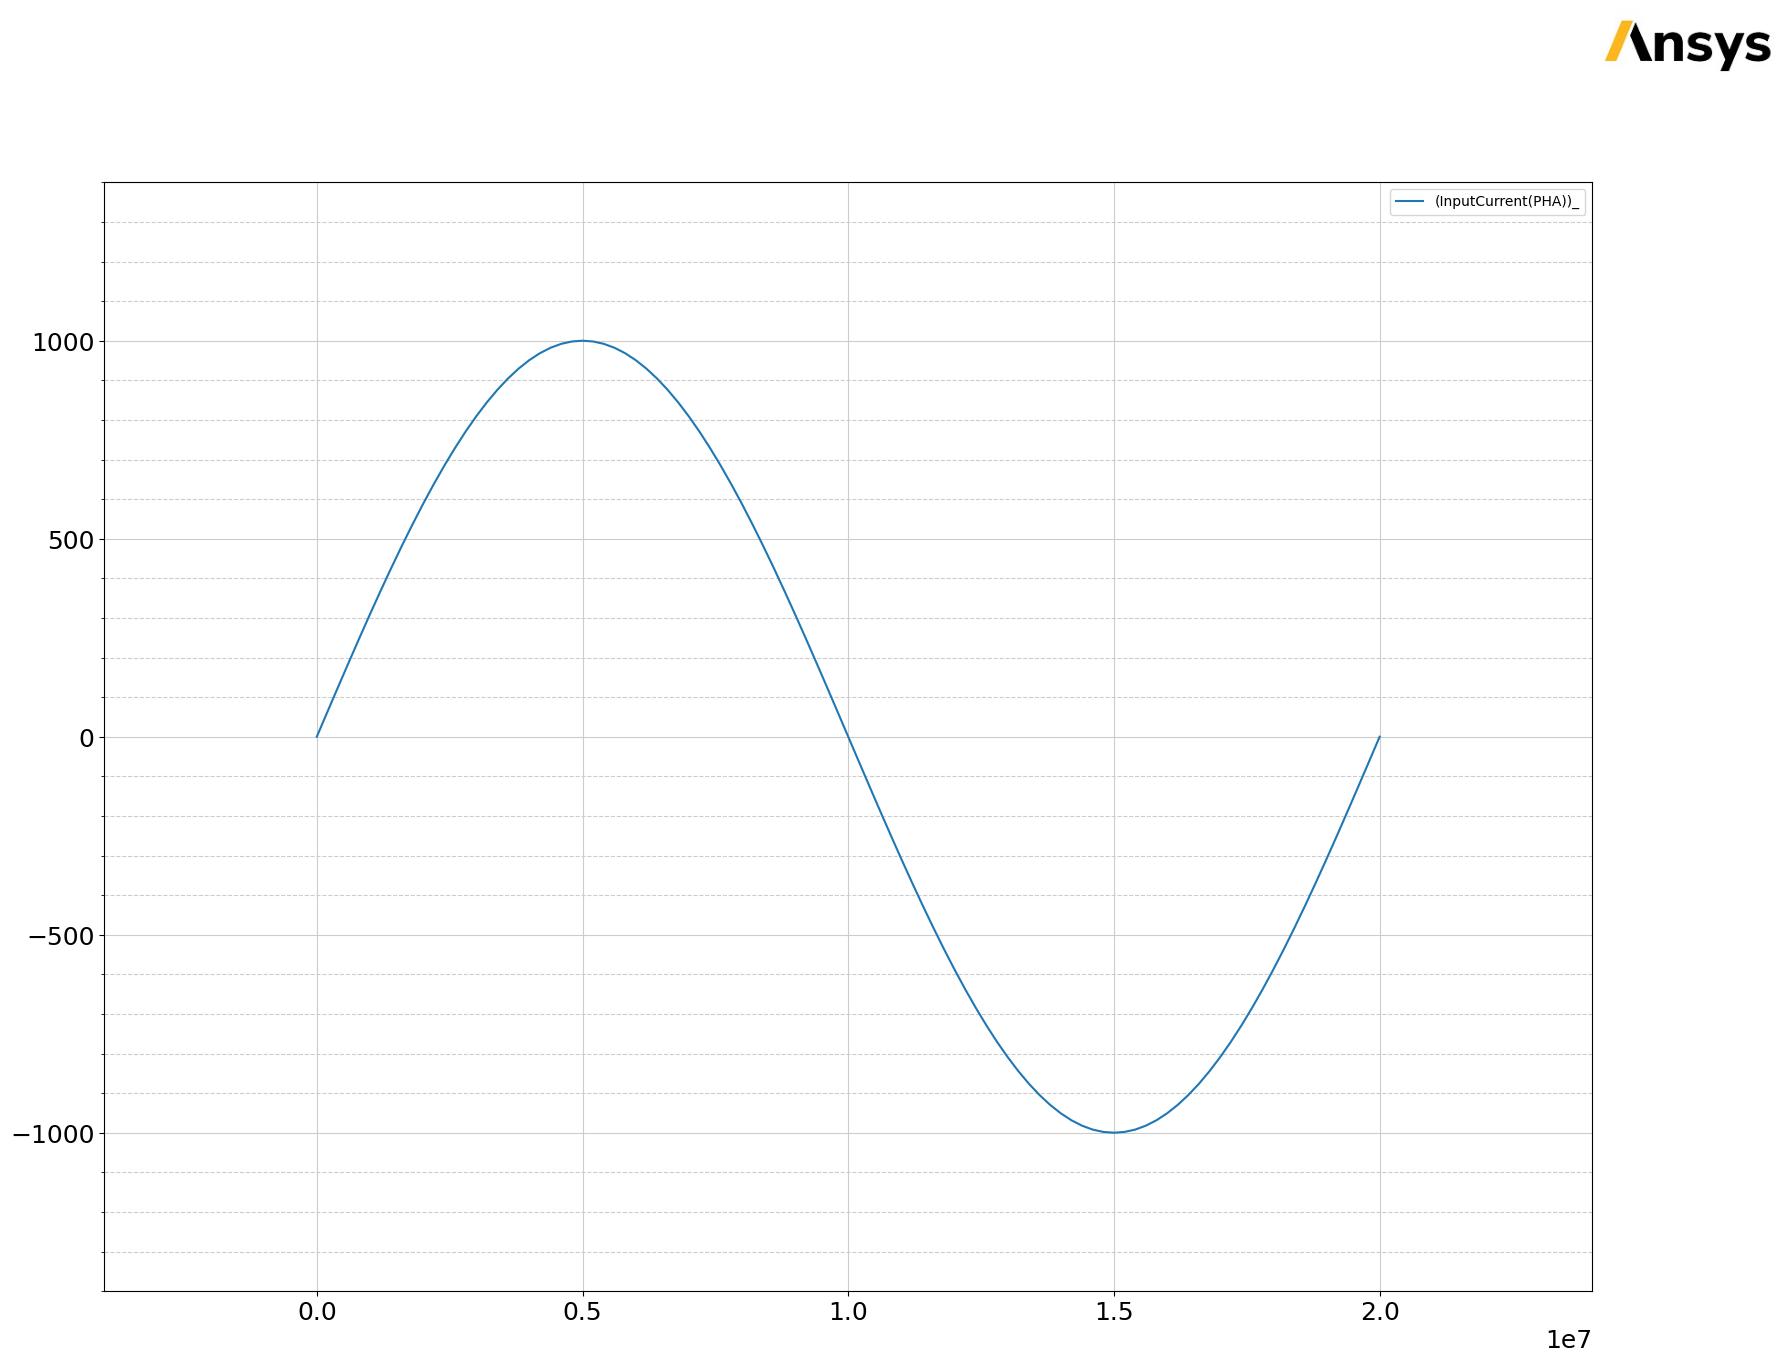

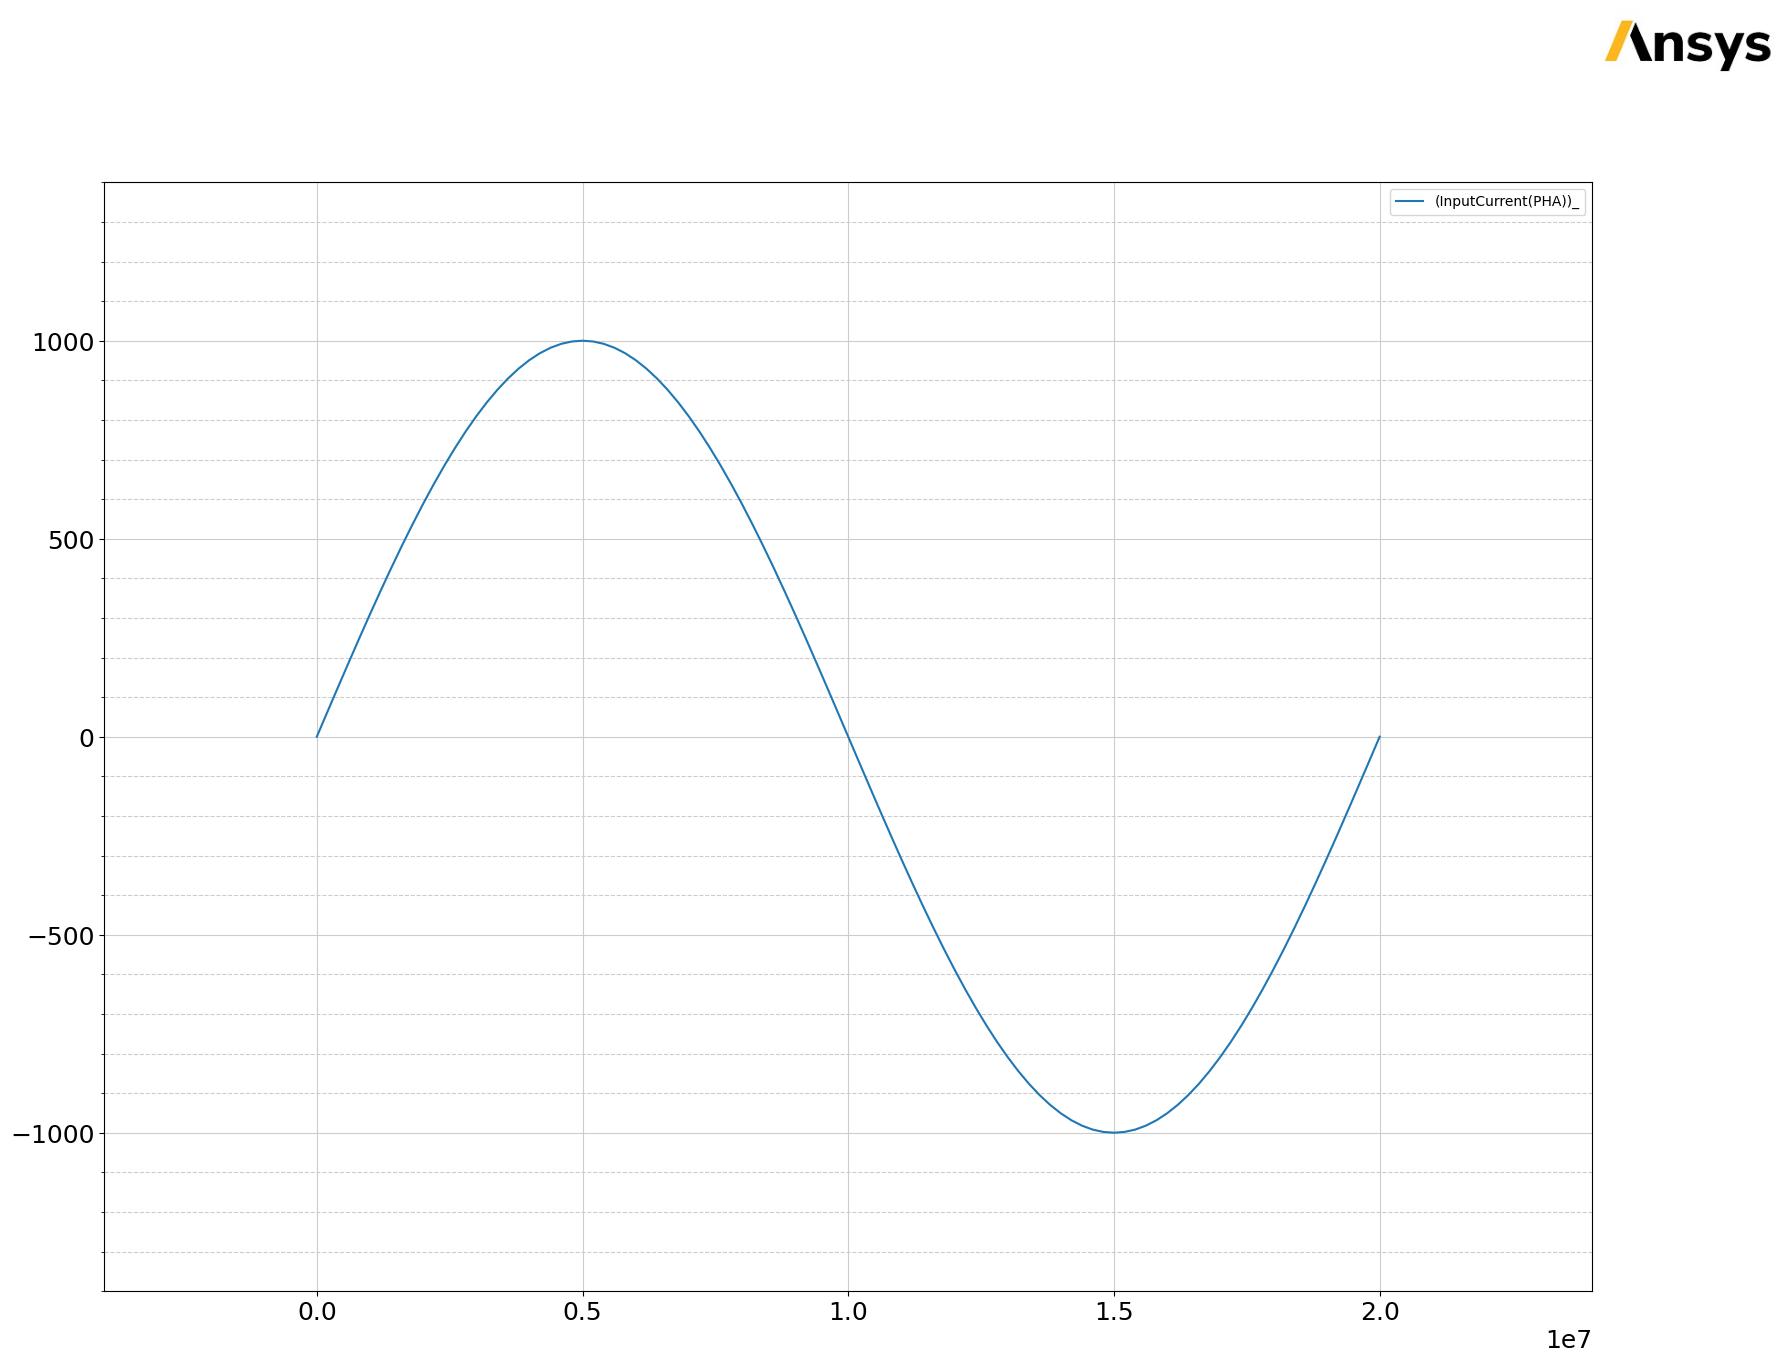

In [12]:
solutions = m2d.post.get_solution_data(expressions="InputCurrent(PHA)", primary_sweep_variable="Time", domain="Sweep")
solutions.plot()

## Release AEDT

In [13]:
m2d.save_project()
m2d.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project Transient Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``.
If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell
removes all temporary files, including the project folder.

In [14]:
temp_folder.cleanup()